## Comparison of Kerr and Schwarzschild metrics implementation

In [2]:
project_path = "../../../../../"
utils_path = project_path * "src/utils/"

output_directory = project_path * "data/output/case_1/kerr/";

In [3]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
import BSON: @save, @load
# gr(); # specify backend for plotting

include(utils_path * "utils.jl")
import_project_utils(utils_path);

  Activating project at `~/Escritorio/TFM/code/01_project`


Initializating weights as zero.


In [4]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_plots_gif = true
save_data = false

# paths
test_name = "kan/"
model_name = "kan/" #"encoder/" #

output_dir = output_directory* "models/" * test_name
solutions_dir = output_dir * "solutions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/"
list_directories = (output_dir, solutions_dir, metrics_dir, img_dir)
create_directories(list_directories)

Create different waveforms:
- Schwarzschild solution
- Kerr solution at limit a -> 0
- Kerr solution at random value a = 0.9

In [54]:
# Define neural network model
NN, NN_params, chain, re = nn_model_case1_arch1_modified(32, tanh);

datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters

χ₀ = Float64(pi/2); 
ϕ₀ = 0.0
p = 20.0
M = 1.0
e = 0.5
tspan_train = (0, 6e3)

train_info = [];
train_info_i = get_pinn_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_train, datasize, dt);
true_info = get_true_solution_EMR_schwarzschild(train_info_i["u0"], train_info_i["model_params"], mass_ratio, M, train_info_i["tspan"], train_info_i["tsteps"], train_info_i["dt_data"], dt)
push!(train_info, merge(train_info_i, true_info))

# TEST waveform parameters

tspan_test = (tspan_train[1], tspan_train[2])
a=1e-5

test_info = [];
test_info_i = get_pinn_EMR_kerr(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_test, datasize, dt);
true_info = get_true_solution_EMR_kerr(test_info_i["u0"], test_info_i["model_params"], mass_ratio, M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
push!(test_info, merge(test_info_i, true_info))

a=0.5
test_info_i = get_pinn_EMR_kerr(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_test, datasize, dt);
true_info = get_true_solution_EMR_kerr(test_info_i["u0"], test_info_i["model_params"], mass_ratio, M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
push!(test_info, merge(test_info_i, true_info))

a=0.9
test_info_i = get_pinn_EMR_kerr(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_test, datasize, dt);
true_info = get_true_solution_EMR_kerr(test_info_i["u0"], test_info_i["model_params"], mass_ratio, M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
push!(test_info, merge(test_info_i, true_info))


# put data in arrays
println("Processing datasets")
datasets = Dict("train" => train_info, "test" => test_info)
processed_data = process_datasets(datasets);


Initializating weights as zero.
Processing datasets
Creating test dataset 
Creating train dataset 


When high spins, amplitudes do not match by phase
When spin = 0, amplitudes do not exactly match due to numerical reasons

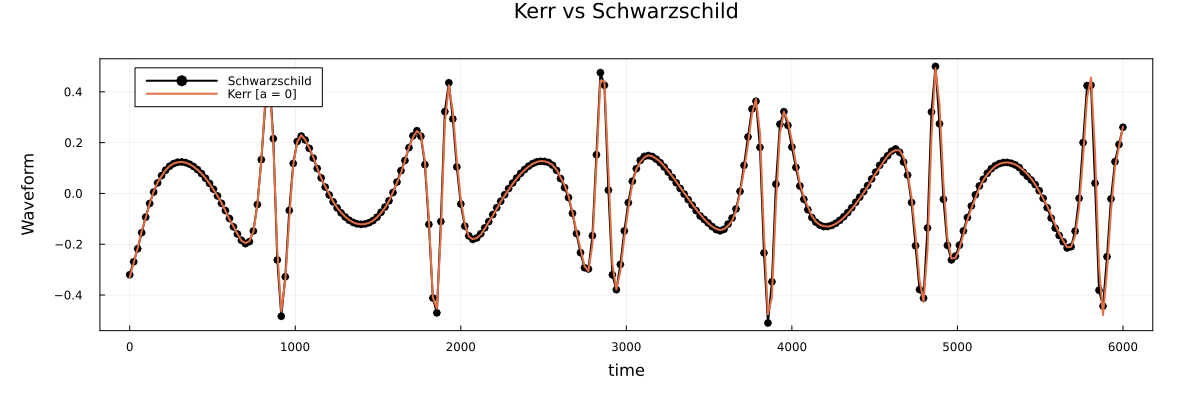

In [55]:
plt = plot(
    processed_data["train"][1]["tsteps"],
    processed_data["train"][1]["true_waveform"],
    label="Schwarzschild",
    ylabel="Waveform",
    xlabel="time",
    framestyle=:box,
    size=(1200,400),
    linewidth=2,
    margin=10Plots.mm,
    title="Kerr vs Schwarzschild",
    marker=:o,
    color=:black
)

plot!(
    plt,
    processed_data["test"][1]["tsteps"],
    processed_data["test"][1]["true_waveform"],
    label="Kerr [a = 0]",
    linewidth=2,
    # marker=:o
)

In [56]:
savefig(plt, "./kerr_schwarzschild.png")

"/home/rubenbalbastre/Escritorio/TFM/code/01_project/src/processing/experiments/kerr/case_1/kerr_schwarzschild.png"

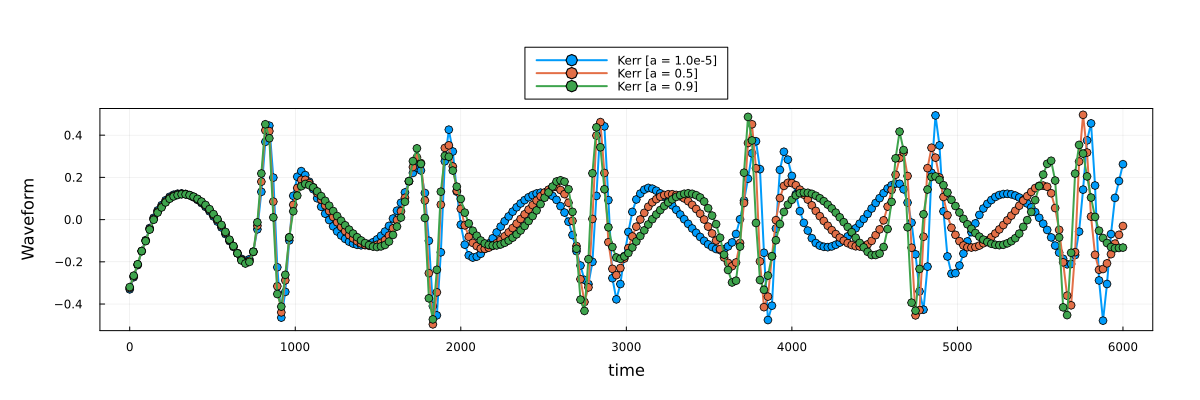

In [57]:
plt = plot(
    processed_data["test"][1]["tsteps"],
    processed_data["test"][1]["true_waveform"],
    label="Kerr [a = " * string(processed_data["test"][1]["model_params"][4]) * "]",
    ylabel="Waveform",
    xlabel="time",
    framestyle=:box,
    size=(1200,400),
    linewidth=2,
    margin=10Plots.mm,
    # title="Train Dataset",
    marker=:o,
    legend=:outertop
)

plot!(
    plt,
    processed_data["test"][2]["tsteps"],
    processed_data["test"][2]["true_waveform"],
    label="Kerr [a = " * string(processed_data["test"][2]["model_params"][4]) * "]",
    marker=:o,
    linewidth=2
)

plot!(
    plt,
    processed_data["test"][3]["tsteps"],
    processed_data["test"][3]["true_waveform"],
    label="Kerr [a = " * string(processed_data["test"][3]["model_params"][4]) * "]",
    marker=:o,
    linewidth=2
)

In [53]:
savefig(plt, "./kerr_train_dataset.png")

"/home/rubenbalbastre/Escritorio/TFM/code/01_project/src/processing/experiments/kerr/case_1/kerr_train_dataset.png"